# VAR(p) processes

We are interested in modeling a $T \times K$ multivariate time series
$Y$, where $T$ denotes the number of observations and $K$ the
number of variables. One way of estimating relationships between the time series
and their lagged values is the *vector autoregression process*:

$$
   Y_t = \nu + A_1 Y_{t-1} + \ldots + A_p Y_{t-p} + u_t
$$
$$
   u_t \sim {\sf Normal}(0, \Sigma_u)
$$

where $A_i$ is a $K \times K$ coefficient matrix.

In [2]:
import pandas as pd
pd.options.display.max_rows = 10
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import numpy as np
import pandas
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str


mdata = sm.datasets.macrodata.load_pandas().data

# prepare the dates index
dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
quarterly = dates_from_str(quarterly)

mdata = mdata[['realgdp','realcons','realinv']]
mdata.index = pandas.DatetimeIndex(quarterly)
data = np.log(mdata).diff().dropna()
data

,realgdp,realcons,realinv
1959-06-30,0.024942,0.015286,0.080213
1959-09-30,-0.001193,0.010386,-0.072131
1959-12-31,0.003495,0.001084,0.034425
1960-03-31,0.022190,0.009534,0.102664
1960-06-30,-0.004685,0.012572,-0.106694
...,...,...,...
2008-09-30,-0.006781,-0.008948,-0.017836
2008-12-31,-0.013805,-0.007843,-0.069165
2009-03-31,-0.016612,0.001511,-0.175598
2009-06-30,-0.001851,-0.002196,-0.067561


### NOTE

The `VAR` assumes that the passed time series are stationary. Non-stationary or trending data can often be transformed to be stationary by first-differencing or some other method. For direct analysis of non-stationary time series, a standard stable VAR(p) model is not appropriate.

In [3]:
model = VAR(data)
results = model.fit(2)
results.summary()

/Users/mranger/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 11, Apr, 2021
Time:                     18:45:17
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.5830
Nobs:                     200.000    HQIC:                  -27.7892
Log likelihood:           1962.57    FPE:                7.42129e-13
AIC:                     -27.9293    Det(Omega_mle):     6.69358e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001527         0.001119            1.365           0.172
L1.realgdp         -0.279435         0.169663           -1.647           0.100
L1.realcons         0.675016         0.131285            5.142    

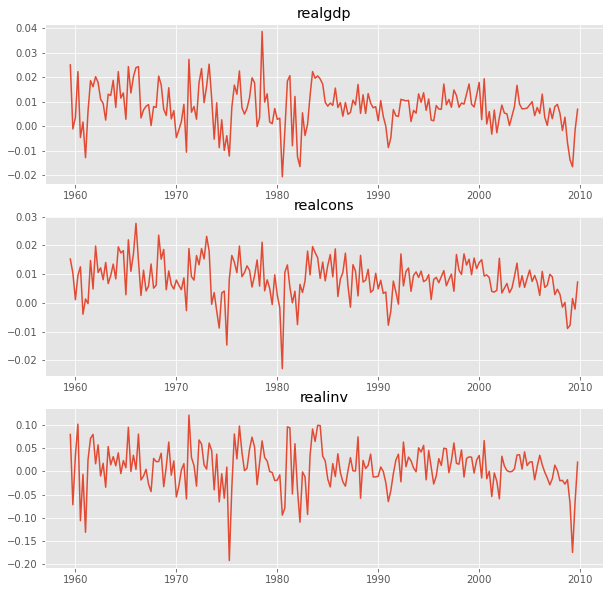

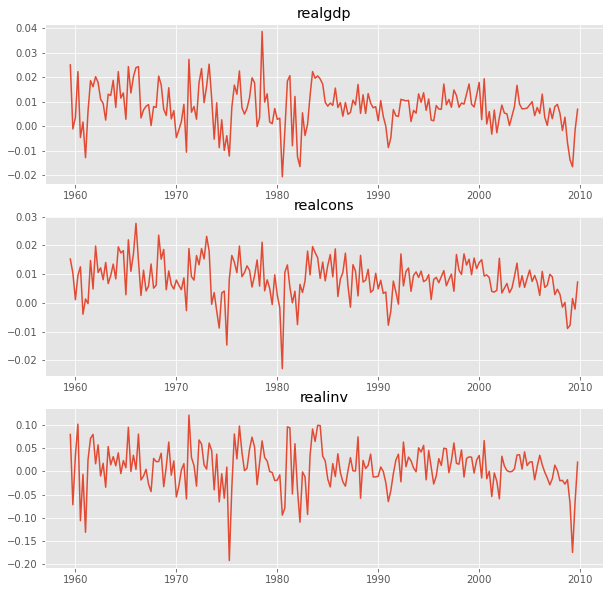

In [4]:
results.plot()

**Automatic Order Selection**

VAR supports automatic order selection (automatic gridsearch, selecting on AIC)

In [5]:
model.select_order(15)

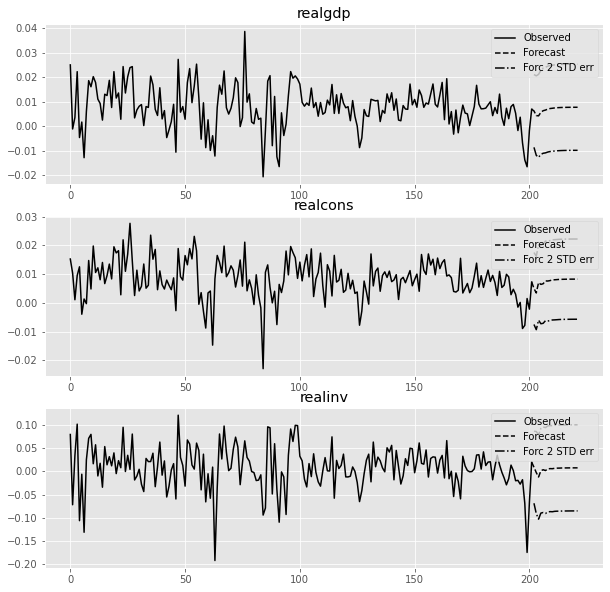

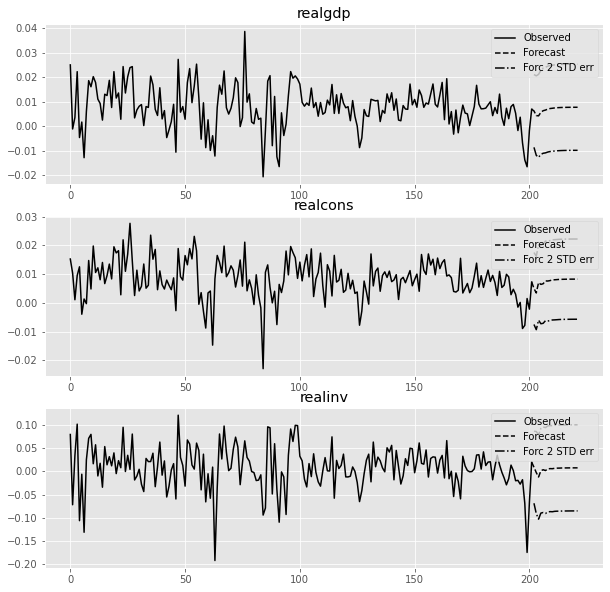

In [6]:
results = model.fit(maxlags=15, ic='aic')
results.plot_forecast(20)

# Impulse Response

Impulse responses are of interest in econometric studies: they are the estimated responses to a unit impulse in one of the variables:



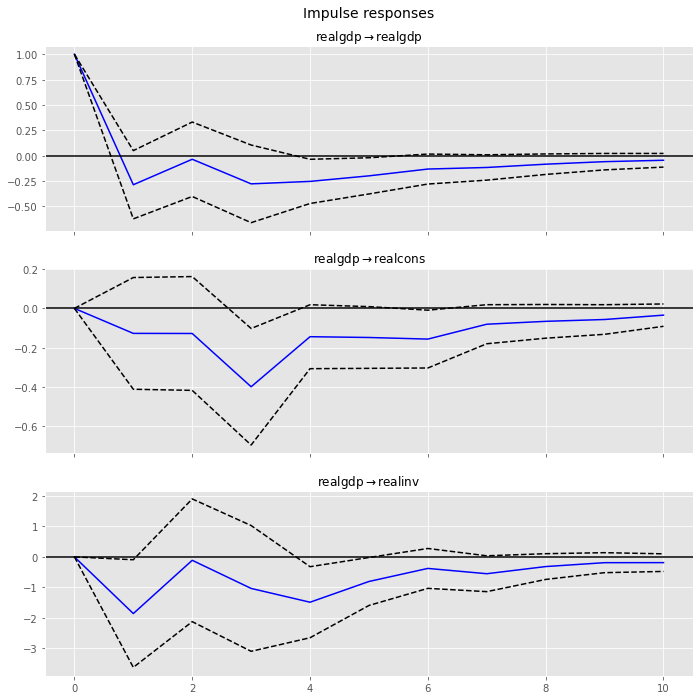

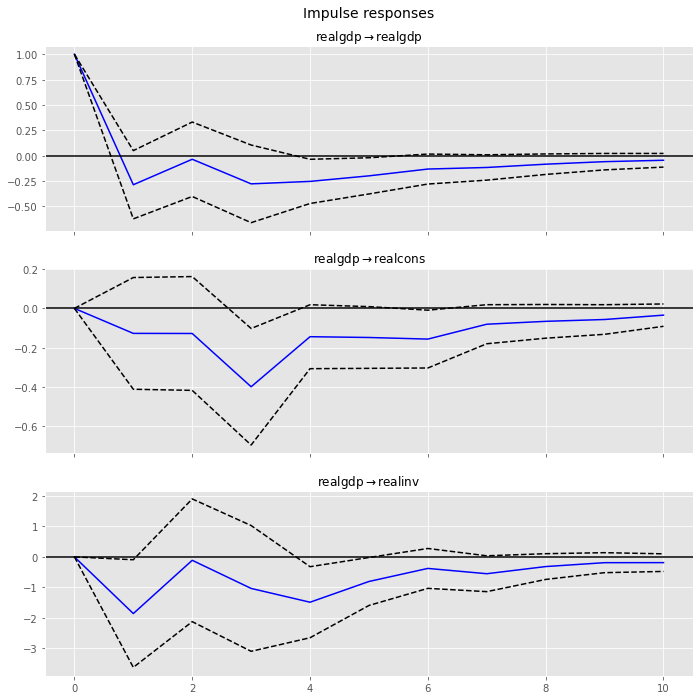

In [7]:
irf = results.irf(10)
irf.plot(impulse='realgdp')

# Granger causality

You may be interested in whether a variable or group of variables is “causal” for another variable.

In the context of VAR models, one can say that a set of variables are **Granger-Causal** within one of the VAR equations. [Granger Causality](https://en.wikipedia.org/wiki/Granger_causality) assumes that:

1. The cause happens prior to its effect.

2. The cause has unique information about the future values of its effect.

So if the lagged value in a series are uniquely identified to cause correlated movement in the future of another, we can say that it "Granger Causes" the movement.

In [17]:
results.test_causality('realgdp', ['realinv', 'realcons'], kind='f').summary()

Test statistic,Critical value,p-value,df
7.000,2.115,0.000,"(6, 567)"


# VARMAX models

This is a brief introduction notebook to VARMAX models in statsmodels. The VARMAX model is generically specified as:
$$
y_t = \nu + A_1 y_{t-1} + \dots + A_p y_{t-p} + B x_t + \epsilon_t +
M_1 \epsilon_{t-1} + \dots M_q \epsilon_{t-q}
$$

where $y_t$ is a $\text{k_endog} \times 1$ vector.

In [18]:
dta = sm.datasets.webuse('lutkepohl2', 'https://www.stata-press.com/data/r12/')
dta.index = dta.qtr
dta.index.freq = dta.index.inferred_freq
endog = dta.loc['1960-04-01':'1978-10-01', ['dln_inv', 'dln_inc', 'dln_consump']]

## Model specification

The `VARMAX` class in statsmodels allows estimation of VAR, VMA, and VARMA models (through the `order` argument), optionally with a constant term (via the `trend` argument). Exogenous regressors may also be included (as usual in statsmodels, by the `exog` argument), and in this way a time trend may be added. Finally, the class allows measurement error (via the `measurement_error` argument) and allows specifying either a diagonal or unstructured innovation covariance matrix (via the `error_cov_type` argument).

## Example 1: VAR

Below is a simple VARX(2) model in two endogenous variables and an exogenous series, but no constant term. Notice that we needed to allow for more iterations than the default (which is `maxiter=50`) in order for the likelihood estimation to converge. This is not unusual in VAR models which have to estimate a large number of parameters, often on a relatively small number of time series: this model, for example, estimates 27 parameters off of 75 observations of 3 variables.

In [19]:
exog = endog['dln_consump']
mod = sm.tsa.VARMAX(endog[['dln_inv', 'dln_inc']], order=(2,0), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

Statespace Model Results                             
Dep. Variable:     ['dln_inv', 'dln_inc']   No. Observations:                   75
Model:                            VARX(2)   Log Likelihood                 361.039
Date:                    Sun, 11 Apr 2021   AIC                           -696.078
Time:                            18:53:53   BIC                           -665.951
Sample:                        04-01-1960   HQIC                          -684.049
                             - 10-01-1978                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            0.05, 10.10   Jarque-Bera (JB):          11.27, 2.45
Prob(Q):                        0.83, 0.00   Prob(JB):                   0.00, 0.29
Heteroskedasticity (H):         0.45, 0.40   Skew:                      0.16, -0.38
Prob(H) (two-sided):            0.05, 0.03   Kurtosis:                   4.87, 3.44
                            R

From the estimated VAR model, we can plot the impulse response functions of the endogenous variables.

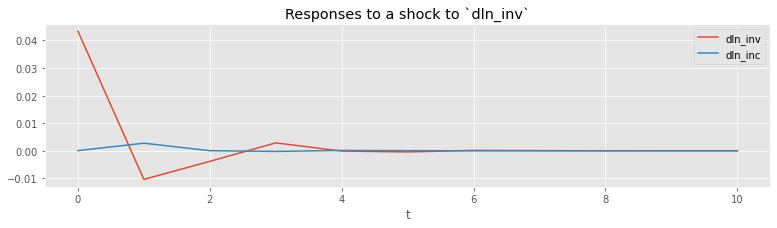

In [13]:
ax = res.impulse_responses(10, orthogonalized=True).plot(figsize=(13,3))
ax.set(xlabel='t', title='Responses to a shock to `dln_inv`');

## Example 2: VMA

A vector moving average model can also be formulated. Below we show a VMA(2) on the same data, but where the innovations to the process are uncorrelated. In this example we leave out the exogenous regressor but now include the constant term.

In [20]:
mod = sm.tsa.VARMAX(endog[['dln_inv', 'dln_inc']], order=(0,2), error_cov_type='diagonal')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

Statespace Model Results                             
Dep. Variable:     ['dln_inv', 'dln_inc']   No. Observations:                   75
Model:                             VMA(2)   Log Likelihood                 353.888
                              + intercept   AIC                           -683.776
Date:                    Sun, 11 Apr 2021   BIC                           -655.966
Time:                            18:54:42   HQIC                          -672.672
Sample:                        04-01-1960                                         
                             - 10-01-1978                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.00, 0.05   Jarque-Bera (JB):         12.78, 13.73
Prob(Q):                        0.96, 0.83   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.44, 0.81   Skew:                      0.06, -0.49
Prob(H) (two-sided):          

## Caution: VARMA(p,q) specifications

Although the model allows estimating VARMA(p,q) specifications, these models are not identified without additional restrictions on the representation matrices, which are not built-in. For this reason, it is recommended that the user proceed with error (and indeed a warning is issued when these models are specified). Nonetheless, they may in some circumstances provide useful information.

In [21]:
mod = sm.tsa.VARMAX(endog[['dln_inv', 'dln_inc']], order=(1,1))
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

/Users/mranger/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
                             Statespace Model Results                             
Dep. Variable:     ['dln_inv', 'dln_inc']   No. Observations:                   75
Model:                         VARMA(1,1)   Log Likelihood                 354.284
                              + intercept   AIC                           -682.568
Date:                    Sun, 11 Apr 2021   BIC                           -652.440
Time:                            18:55:08   HQIC                          -670.538
Sample:                        04-01-1960                                         
                             - 10-01-1978                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q)

# ARMAX

An alternative to using a VAR when we have multiple time series is to use the ARMAX specification.

When exogenous regressors are included, the SARIMAX module uses the concept of "regression with SARIMA errors" (see http://robjhyndman.com/hyndsight/arimax/ for details of regression with ARIMA errors versus alternative specifications), so that the model is specified as:

$$
y_t = \beta_t x_t + u_t \\
        \phi_p (L) \tilde \phi_P (L^s) \Delta^d \Delta_s^D u_t = A(t) +
            \theta_q (L) \tilde \theta_Q (L^s) \epsilon_t
$$

The first equation is just a linear regression.

The second equation describes the process followed by the error component as SARIMA.

This specification nests many simpler specifications. For example, regression with AR(2) errors is:

$$
y_t = \beta_t x_t + u_t \\
(1 - \phi_1 L - \phi_2 L^2) u_t = A(t) + \epsilon_t
$$

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

# Dataset
friedman2 = requests.get('https://www.stata-press.com/data/r12/friedman2.dta').content
data = pd.read_stata(BytesIO(friedman2))
data.index = data.time
data.index.freq = "QS-OCT"

data = data.loc['1959':'1981']

# Variables
endog = data.loc[:, 'consump']
exog = sm.add_constant(data.loc[:, 'm2'])
data

,m2,time,m1,consump,pc92
time,,,,,
1959-01-01,289.149994,1959-01-01,139.740005,310.399994,1369.900024
1959-04-01,294.049988,1959-04-01,141.169998,316.399994,1391.699951
1959-07-01,296.730011,1959-07-01,141.009995,321.700012,1407.199951
1959-10-01,297.799988,1959-10-01,139.949997,323.799988,1409.500000
1960-01-01,299.350006,1960-01-01,139.750000,327.299988,1422.500000
...,...,...,...,...,...
1980-10-01,1601.099976,1980-10-01,408.920013,1836.800049,3034.199951
1981-01-01,1638.000000,1981-01-01,418.920013,1890.300049,3045.600098
1981-04-01,1670.550049,1981-04-01,423.899994,1923.500000,3045.800049


In [2]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(1,0,1))
res = mod.fit(disp=False)
print(res.summary())

SARIMAX Results                                
Dep. Variable:                consump   No. Observations:                   92
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -340.508
Date:                Sun, 11 Apr 2021   AIC                            691.015
Time:                        21:58:25   BIC                            703.624
Sample:                    01-01-1959   HQIC                           696.105
                         - 10-01-1981                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -36.0607     56.643     -0.637      0.524    -147.078      74.957
m2             1.1220      0.036     30.825      0.000       1.051       1.193
ar.L1          0.9348      0.041     22.717      0.000       0.854       1.015
ma.L